In [37]:
import scipy.special as sc
import pandas as pd
import numpy as np

# calculating Bayes factors for differential gene expression (BF_21)
def get_BF(N_1, n_1, N_2, n_2):

    return (sc.betaln( u_1 + n_1, u_2 + N_1 - n_1) + sc.betaln( u_1 + n_2, u_2 + N_2 - n_2) - sc.betaln( u_1 + n_1 + n_2, u_2 + N_1 - n_1 + N_2 - n_2)) / np.log(10) 

# ratio of expression 
# calculating log fold change
def get_FC(N_1, n_1, N_2, n_2):
    rate_1 = (u_1 + n_1) / (u_2 + N_1 - n_1)
    rate_2 = (u_1 + n_2) / (u_2 + N_2 - n_2)

    return np.log2(rate_2 / rate_1)

# calculating q (following Laplace's rule of succession)
# expected expression probability

def get_q(n, N):
    return (n+1)/(N+2)

# setting the priors to flat prios
u_1 = 1
u_2 = 1


# calculating Bayes factors (BF_IC) for consistency 

# input data is a data frame containing all read counts for all genes (rows) and replicates (colums)

def get_BF_IC(data):
    # this range is irrelevant if we want to do all replicates
    k = len(data.columns)

    evidence2 = np.full(len(data), 0)

    # iterating over j until k
    for col in data.columns[1:k]: 
        n_j = data[col]
        # print(n_j, 'n_j')
        N_j = sum(data[col])
        # print(N_j, 'N_j')
        evidence2 = evidence2 + sc.betaln(u_1 + n_j, u_2 + N_j - n_j)

    N = sum(data.iloc[:,1:k].sum(axis=0, numeric_only=True))
    n_i = data.iloc[:,1:k].sum(axis=1, numeric_only=True)

    # print(n_i, 'n_i')
    # print(N, 'N')

    evidence1 = sc.betaln( u_1 + n_i, u_2 + N - n_i)

    return (evidence2 - evidence1) / np.log(10) 


In [38]:
### Example test frame

# Read counts for 5 genes in two different experiments (cound be conditions, developmental timepoints, ...) with 3 replicates each.
    
in_data = pd.DataFrame({'genes': ['gene1', 'gene2', 'gene3', 'gene4', 'gene5'],
                        'exp 1 rep 1': [10, 100, 1000, 10000, 1000],
                        'exp 1 rep 2': [12, 120, 1200, 12000, 1000],
                        'exp 1 rep 3': [8, 80, 1100, 11000, 1000],
                        'exp 2 rep 1': [100, 100, 1200, 12000, 1000],
                        'exp 2 rep 2': [120, 120, 1300, 13000, 1000],
                        'exp 2 rep 3': [80, 80, 1400, 14000, 1000]
                        })

in_data

,genes,exp 1 rep 1,exp 1 rep 2,exp 1 rep 3,exp 2 rep 1,exp 2 rep 2,exp 2 rep 3
0,gene1,10,12,8,100,120,80
1,gene2,100,120,80,100,120,80
2,gene3,1000,1200,1100,1200,1300,1400
3,gene4,10000,12000,11000,12000,13000,14000
4,gene5,1000,1000,1000,1000,1000,1000


In [39]:
### Calculating Bayes factors (BF_21) and inferred fold change values

out_data = pd.DataFrame({'genes': in_data.genes})

# n_1 is the sum of all read counts in experiment 1 (replicates 1-3)
n_1 = in_data.iloc[:,1:4].sum(axis=1)

# n_2 is the sum of all read counts in experiment 2 (replicates 1-3)
n_2 = in_data.iloc[:,4:].sum(axis=1)

# N_1 and N_2 are the total number of reads in experiments 1 and 2, respectively
N_1 = in_data.iloc[:,1:4].sum(axis=1).sum()
N_2 = in_data.iloc[:,4:].sum(axis=1).sum()

out_data['BF'] = get_BF(N_1, n_1, N_2, n_2)
out_data['FC'] = get_FC(N_1, n_1, N_2, n_2)

out_data

,genes,BF,FC
0,gene1,43.703090,3.057036
1,gene2,-2.007143,-0.232257
2,gene3,-2.302165,0.011255
3,gene4,-0.975450,0.063145
4,gene5,6.581409,-0.247983


In [43]:
# Furthermore, you can calculate a Bayes factor for consistency from that (very limited!) data

# input data is a data frame containing all read counts for all genes (rows) and replicates (colums)
exp_1 = in_data.iloc[:,1:4]
exp_2 = in_data.iloc[:,4:]

display(exp_1)
display(exp_2)


out_data['BF_IC_1'] = get_BF_IC(exp_1)
out_data['BF_IC_2'] = get_BF_IC(exp_2)

out_data

,exp 1 rep 1,exp 1 rep 2,exp 1 rep 3
0,10,12,8
1,100,120,80
2,1000,1200,1100
3,10000,12000,11000
4,1000,1000,1000


,exp 2 rep 1,exp 2 rep 2,exp 2 rep 3
0,100,120,80
1,100,120,80
2,1200,1300,1400
3,12000,13000,14000
4,1000,1000,1000


,genes,BF,FC,BF_IC_1,BF_IC_2
0,gene1,43.703090,3.057036,-2.981373,-0.305491
1,gene2,-2.007143,-0.232257,-1.488666,-0.305491
2,gene3,-2.302165,0.011255,-2.075284,-2.091895
3,gene4,-0.975450,0.063145,-1.839520,-0.967662
4,gene5,6.581409,-0.247983,-1.294648,-1.701523


In [74]:
# get q values for all genes in all replicates for the q plots

exp_1_q = pd.DataFrame({})

for col in exp_1.columns:

    exp_1_q[col+'_q'] = (exp_1[col]+1) / (sum(exp_1[col])+2)

display(exp_1_q)

exp_2_q = pd.DataFrame({})

for col in exp_2.columns:

    exp_2_q[col+'_q'] = (exp_2[col]+1) / (sum(exp_2[col])+2)

display(exp_2_q)

,exp 1 rep 1_q,exp 1 rep 2_q,exp 1 rep 3_q
0,0.000908,0.000907,0.000682
1,0.008339,0.008441,0.006141
2,0.082645,0.083787,0.083472
3,0.825710,0.837240,0.834041
4,0.082645,0.069834,0.075891


,exp 2 rep 1_q,exp 2 rep 2_q,exp 2 rep 3_q
0,0.007013,0.007785,0.004891
1,0.007013,0.007785,0.004891
2,0.083391,0.083709,0.084591
3,0.833287,0.836508,0.845369
4,0.069504,0.064406,0.060440


In [82]:
# plotting expected expression probabilities q_i for genes i across replicates

import matplotlib.pyplot as plt

def q_plot(exp_1, exp_2):

    # printing q-plots
    for t in range(len(exp_1)):
        fig, ax = plt.subplots(dpi=300)

        # histogram Exp 1
        ax.hist(exp_1.iloc[t], 10, density=False, histtype='step', color='#332288',
                alpha=0.4, orientation='horizontal')

        # histogram Exp 2
        ax.hist(exp_2.iloc[t], 10, density=False, histtype='step', color='#DDCC77',
                alpha=0.4, orientation='horizontal')


        # scatter Exp 1
        ax.scatter(np.arange(1,len(exp_1.columns)+1), exp_1.iloc[t],
                
            c='#332288', s=30, 
            label='Experiment 1',
            alpha=0.9, edgecolors='none')
        
        # scatter Exp 2
        ax.scatter(np.arange(1,len(exp_2.columns)+1), exp_2.iloc[t],
                
            c='#DDCC77', s=30, 
            label='Experiment 2',
            alpha=0.9, edgecolors='none')
        
        ax.legend(loc='upper right')

        # Use tex in labels
        ax.set_xticks(np.arange(1,len(exp_1.columns)+1))
        ax.set_xticklabels('')

        # formatting y axis ticks
        plt.gca().ticklabel_format(axis='y', style='plain', useOffset=False)

        ax.set_xlabel('Replicates')
        ax.set_ylabel('q = (n+1) / (N+2)')

        plt.show()



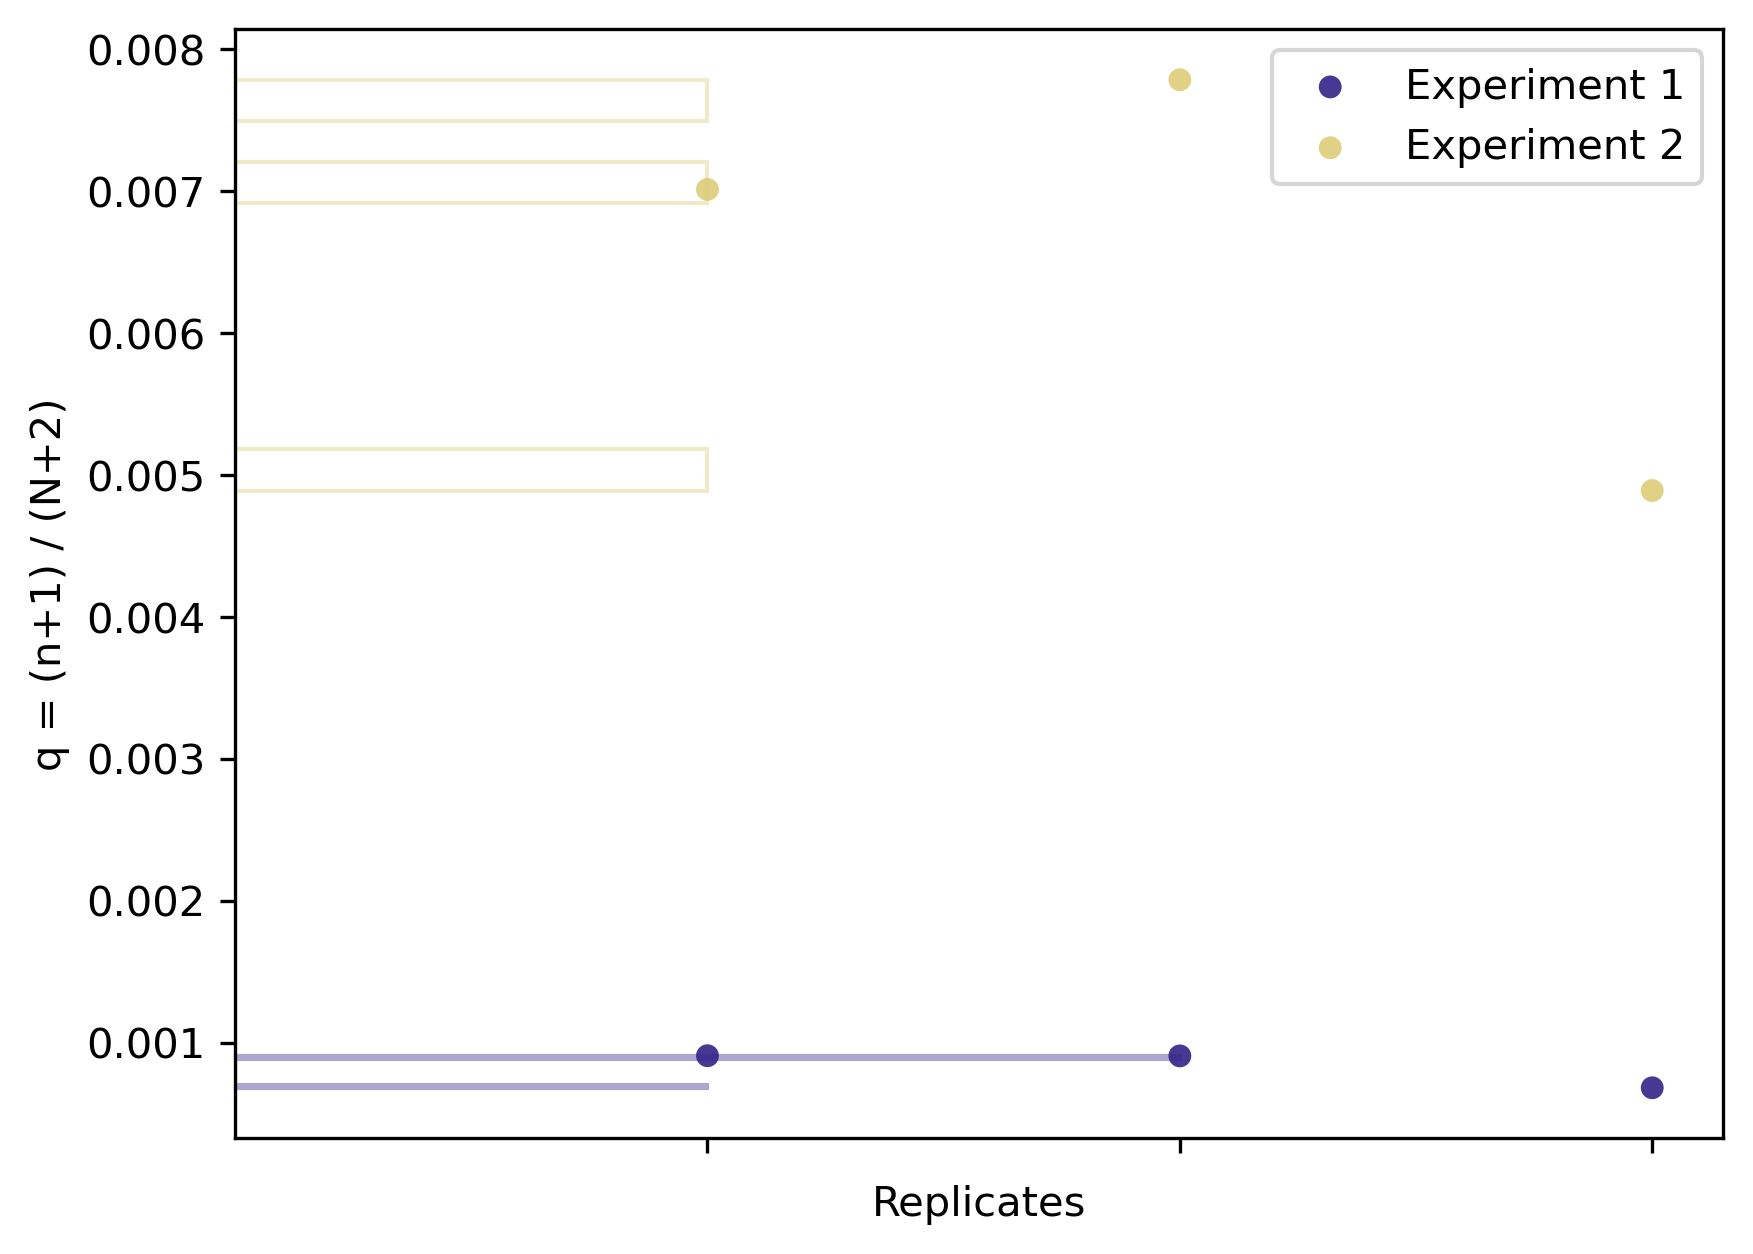

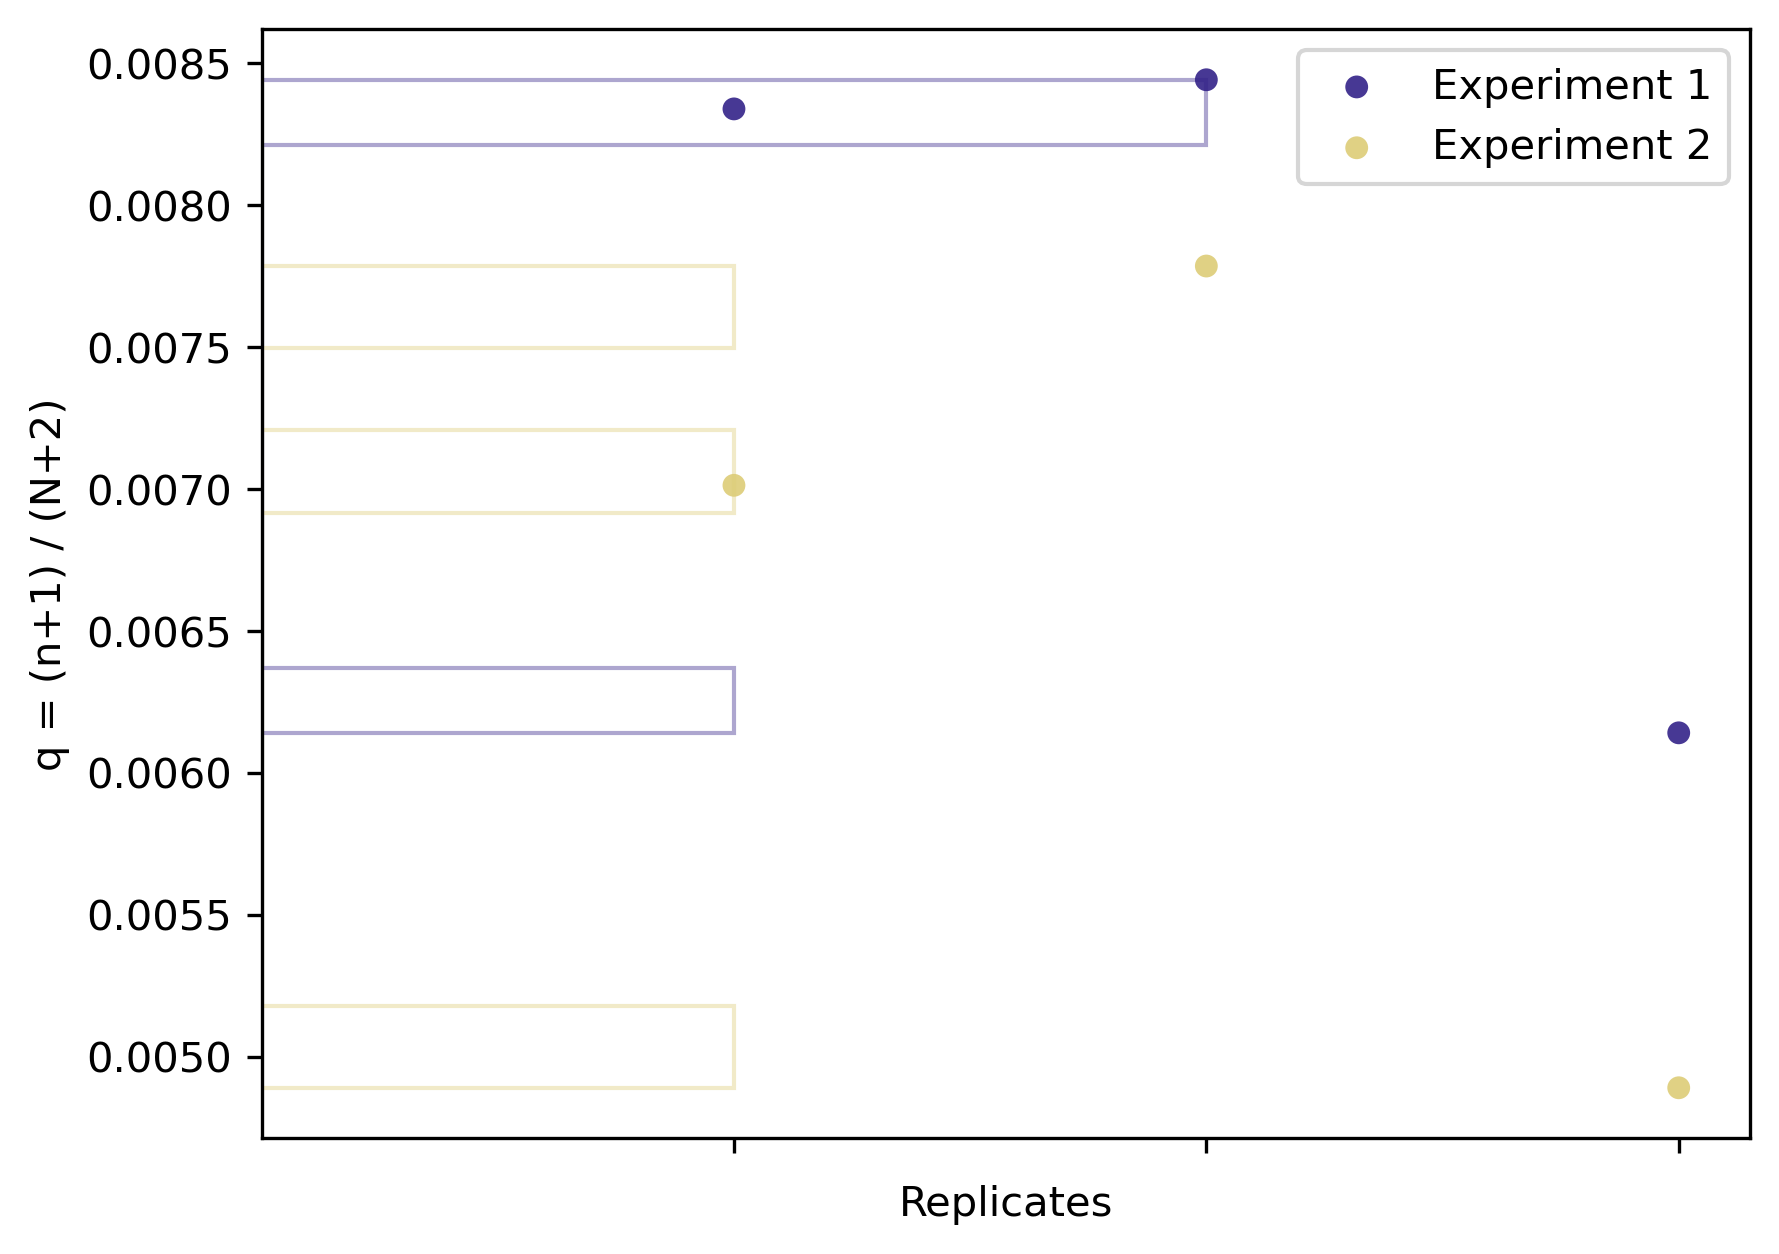

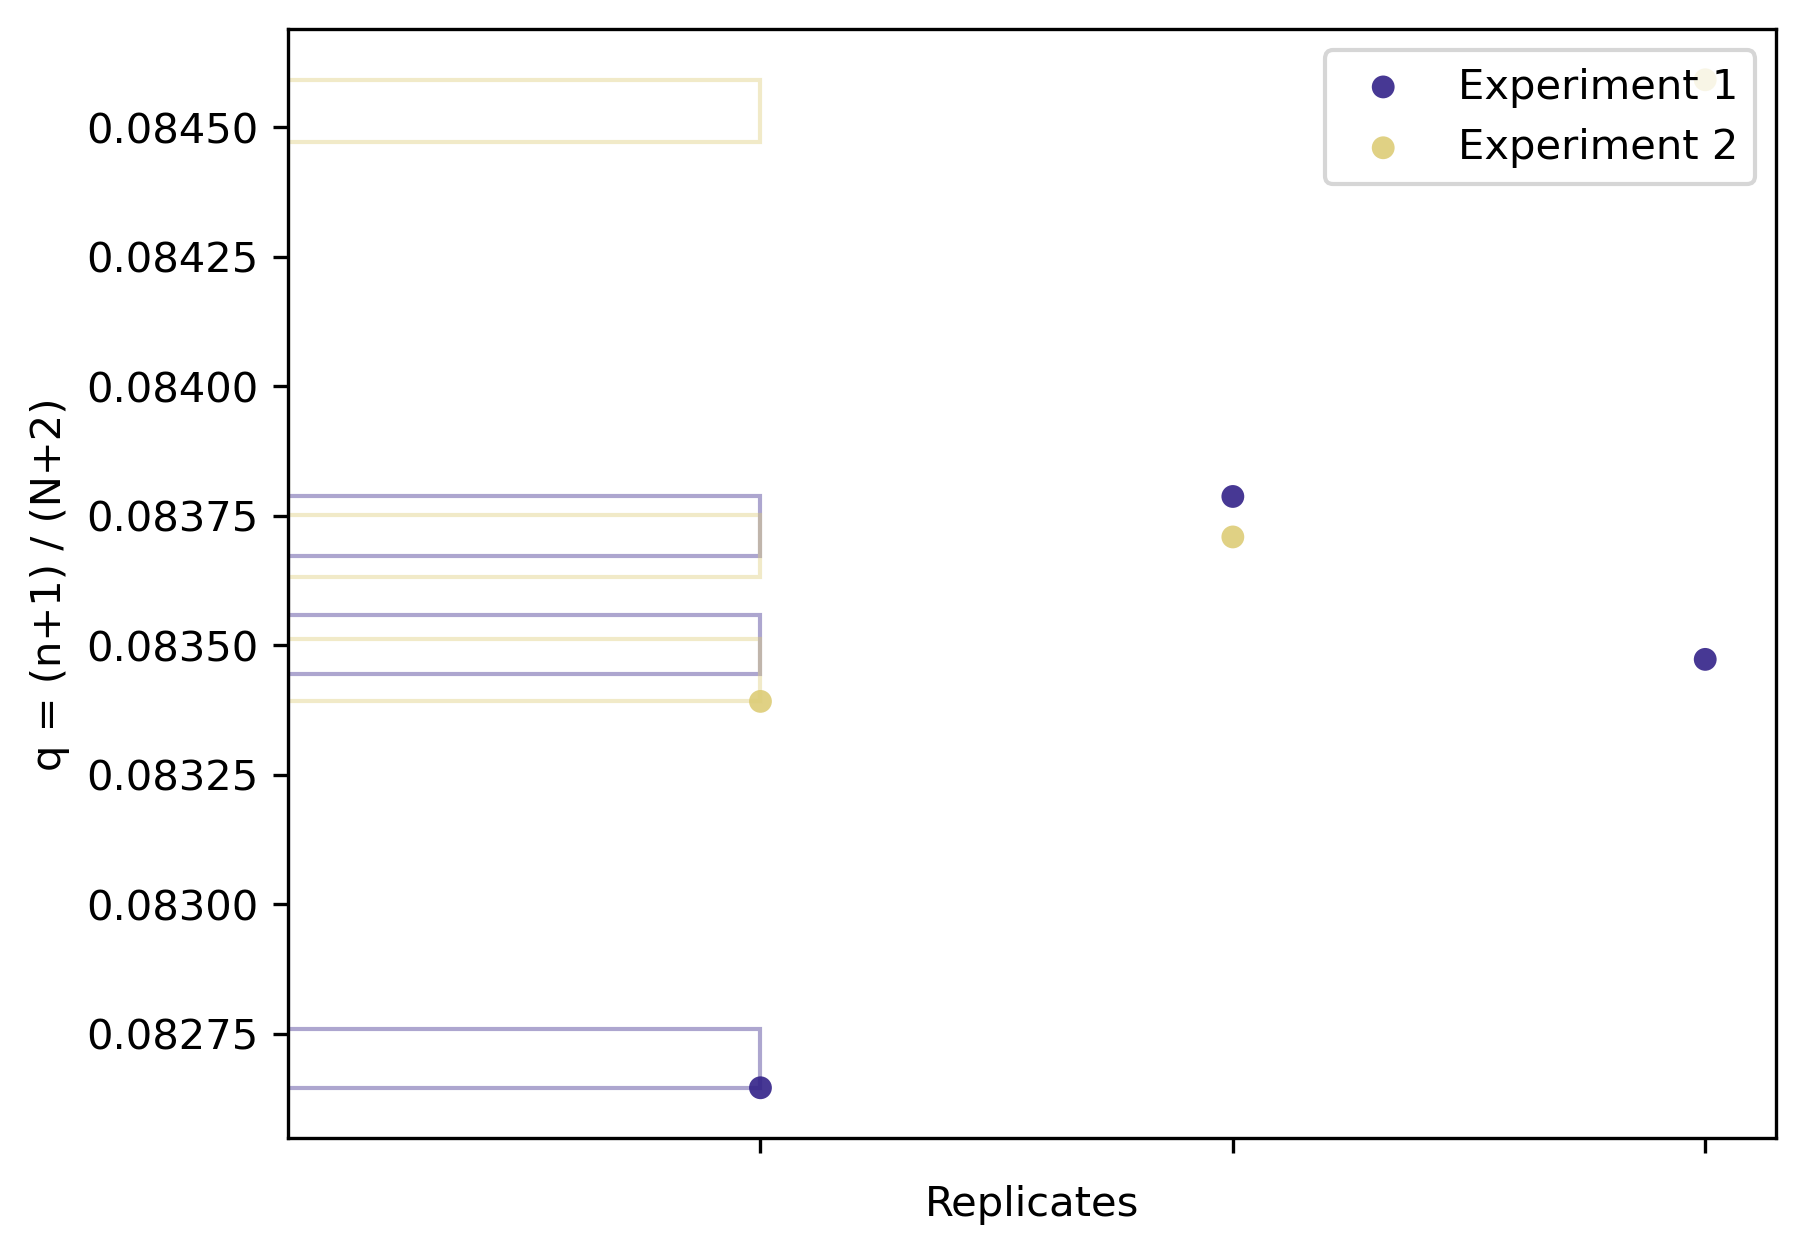

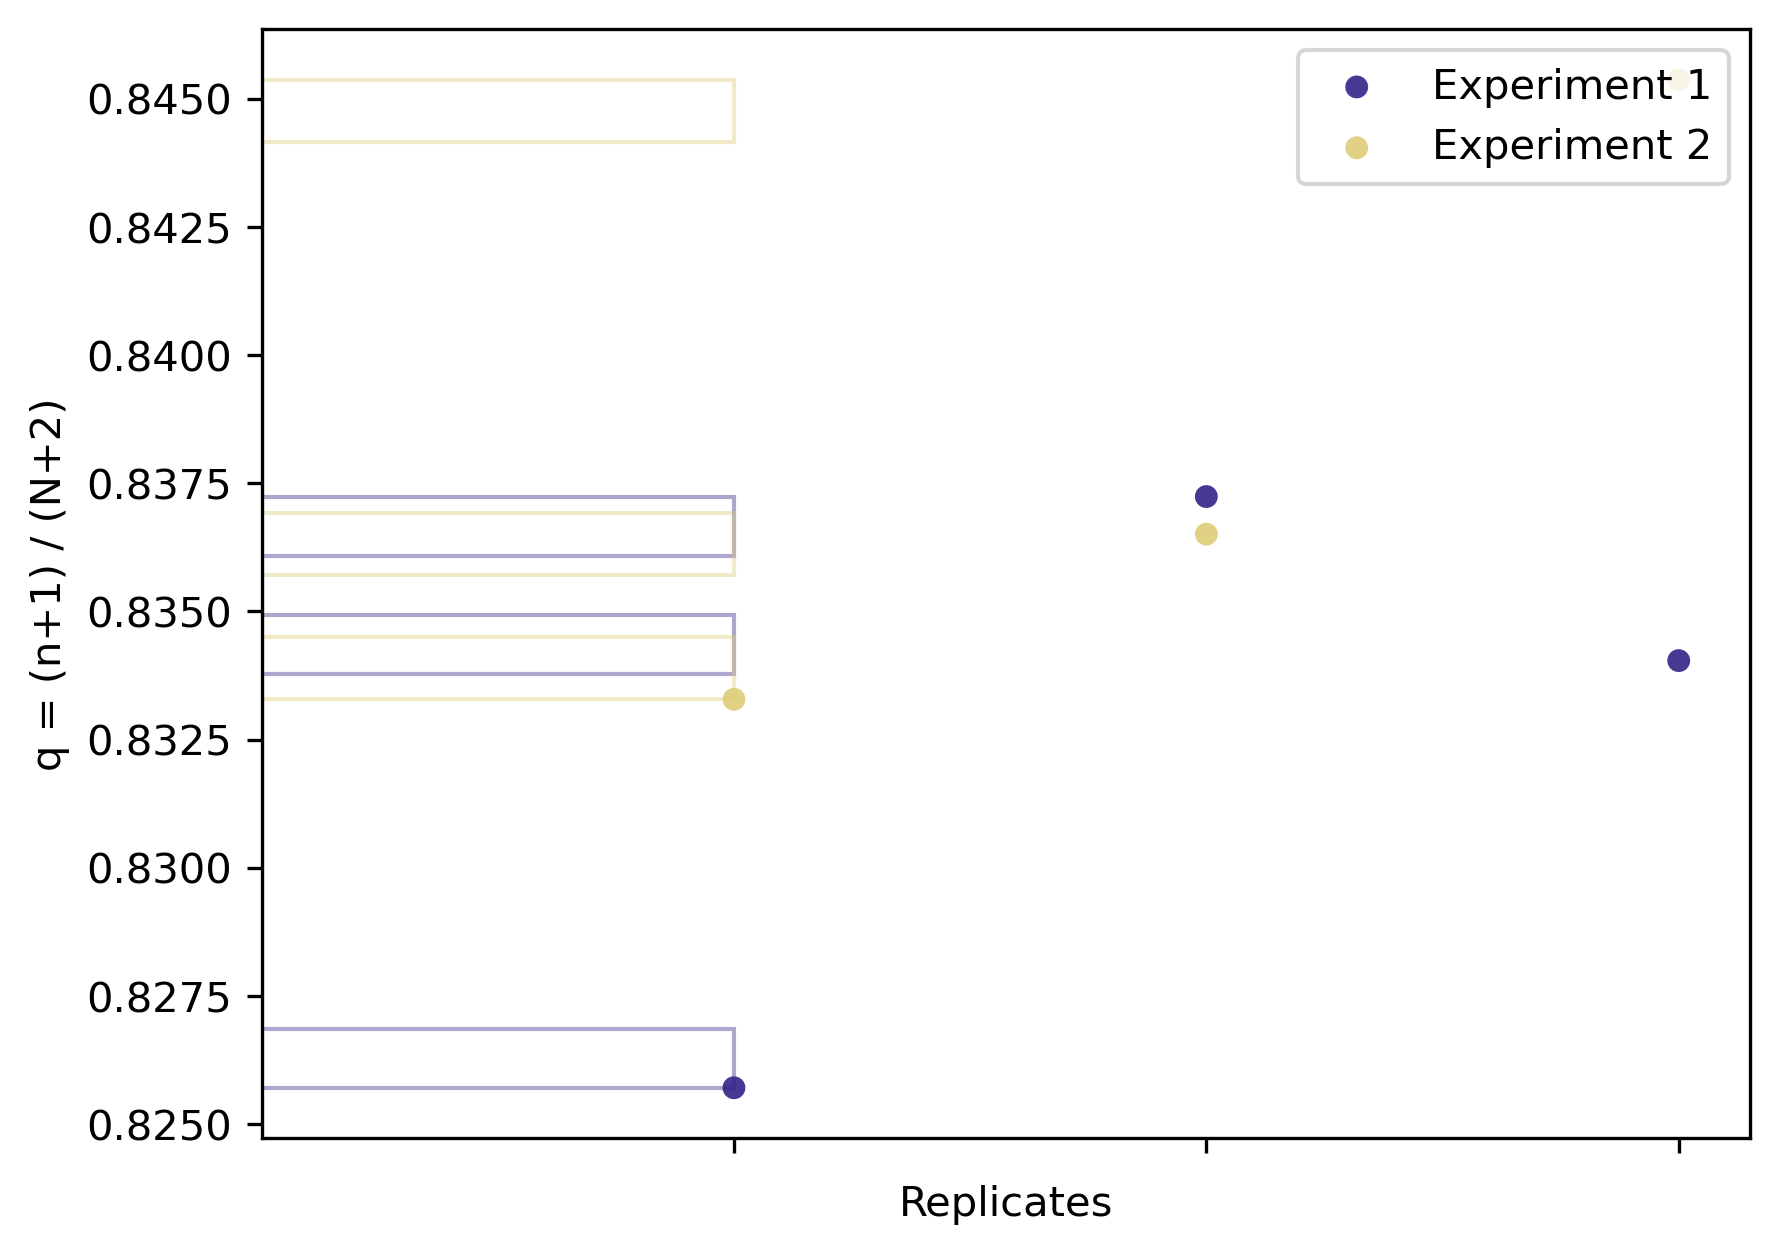

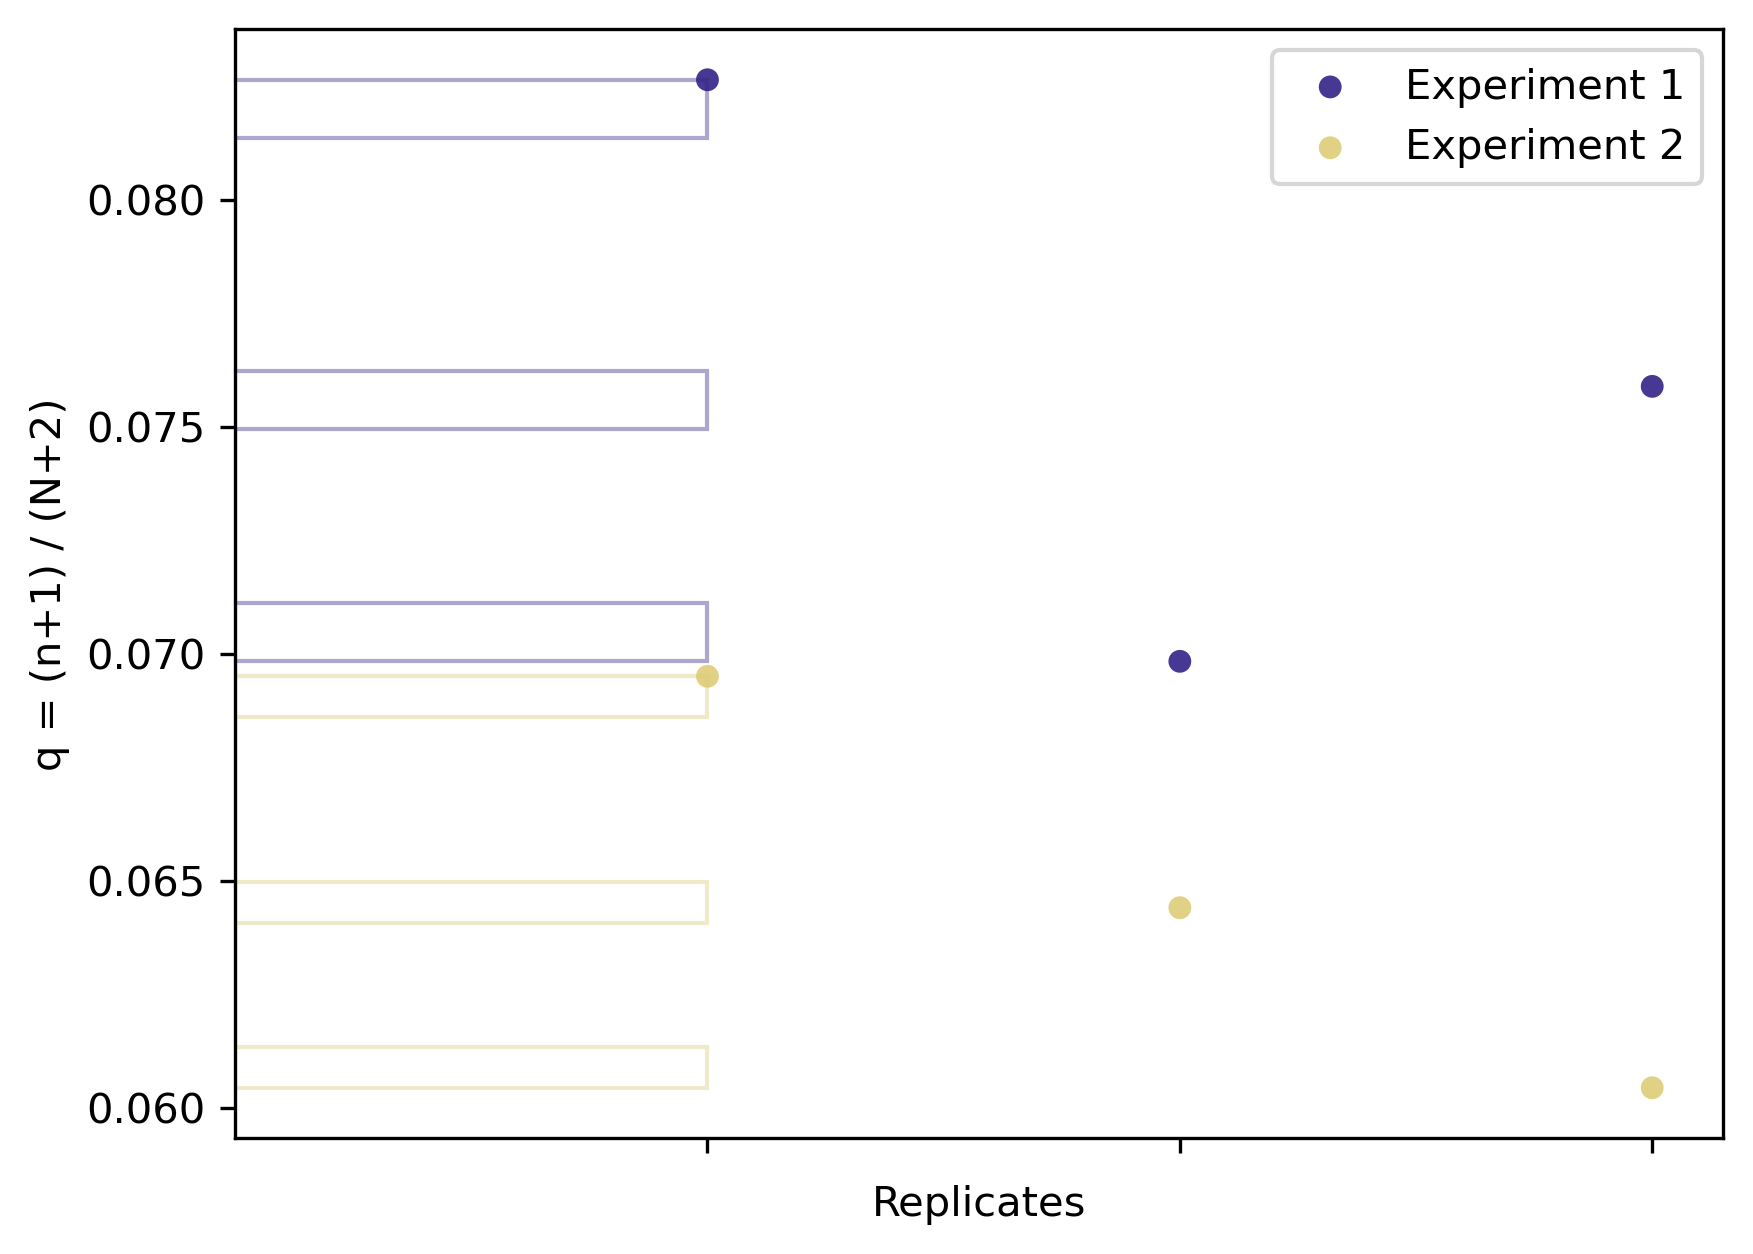

In [84]:
# input q value tables

q_plot(exp_1_q, exp_2_q)

# does not make a lot of sense or a good plot with 3 reps anyways 